In [1]:
from comet import COMET
from models.encoder import FTClassifier
# import datautils
from tasks.fine_tuning import finetune_fit
from tasks.fine_tuning import finetune_predict
from tasks.linear_evaluation import eval_classification
from dataloading.tdbrain_preprocessing import load_tdbrain
from config_files.TDBrain_Configs import Config as Configs

import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
import sklearn
from utils import plot_channels
from utils import process_batch_ts
from utils import split_data_label
from utils import start_logging
from utils import stop_logging
from utils import seed_everything

from datetime import datetime

C:\Users\24700\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\24700\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\24700\AppData\Local\Programs\Python\Python3

In [2]:
configs = Configs()
RANDOM_SEED = configs.RANDOM_SEED

# Autoload the modified python file
%reload_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Specify saving and logging directory

In [3]:
working_directory = 'test_run/models/TDBrain/'
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

logging_directory = 'test_run/logs/TDBrain/'
if not os.path.exists(logging_directory):
    os.makedirs(logging_directory)

#### Load and preprocessing data

In [4]:
data_path = "datasets/TDBRAIN/Feature/"
label_path = "datasets/TDBRAIN/Label/label.npy"
train_ids = list(range(1,18)) + list(range(29,46))  # specify patient ID for training, validation, and test set
val_ids = [18, 19, 20, 21] + [46, 47, 48, 49]  # 8 patients, 4 positive 4 healthy
test_ids = [22, 23, 24, 25] + [50, 51, 52, 53]  # 8 patients, 4 positive 4 healthy"""
X_trial_train, X_trial_val, X_trial_test, y_trial_train, y_trial_val, y_trial_test = load_tdbrain(train_ids, val_ids, test_ids, data_path, label_path)
print(X_trial_train.shape)
print(y_trial_train.shape)
print(X_trial_val.shape)
print(y_trial_val.shape)
print(X_trial_test.shape)
print(y_trial_test.shape)

Validation subjects:  [18, 19, 20, 21, 46, 47, 48, 49]
Test subjects:  [22, 23, 24, 25, 50, 51, 52, 53]
(432, 2560, 33)
(432, 2)
(96, 2560, 33)
(96, 2)
(96, 2560, 33)
(96, 2)


In [5]:
# normalize data
X_trial_train = process_batch_ts(X_trial_train, normalized=True, bandpass_filter=False)
X_trial_val = process_batch_ts(X_trial_val, normalized=True, bandpass_filter=False)
X_trial_test = process_batch_ts(X_trial_test, normalized=True, bandpass_filter=False)
print(X_trial_train.shape)
print(X_trial_val.shape)
print(X_trial_test.shape)

(432, 2560, 33)
(96, 2560, 33)
(96, 2560, 33)


In [6]:
# Split trail-level data into sample-level data
X_train, y_train = split_data_label(X_trial_train,y_trial_train, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
X_val, y_val = split_data_label(X_trial_val,y_trial_val, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
X_test, y_test = split_data_label(X_trial_test,y_trial_test, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(8208, 256, 33)
(1824, 256, 33)
(1824, 256, 33)
(8208, 3)
(1824, 3)
(1824, 3)


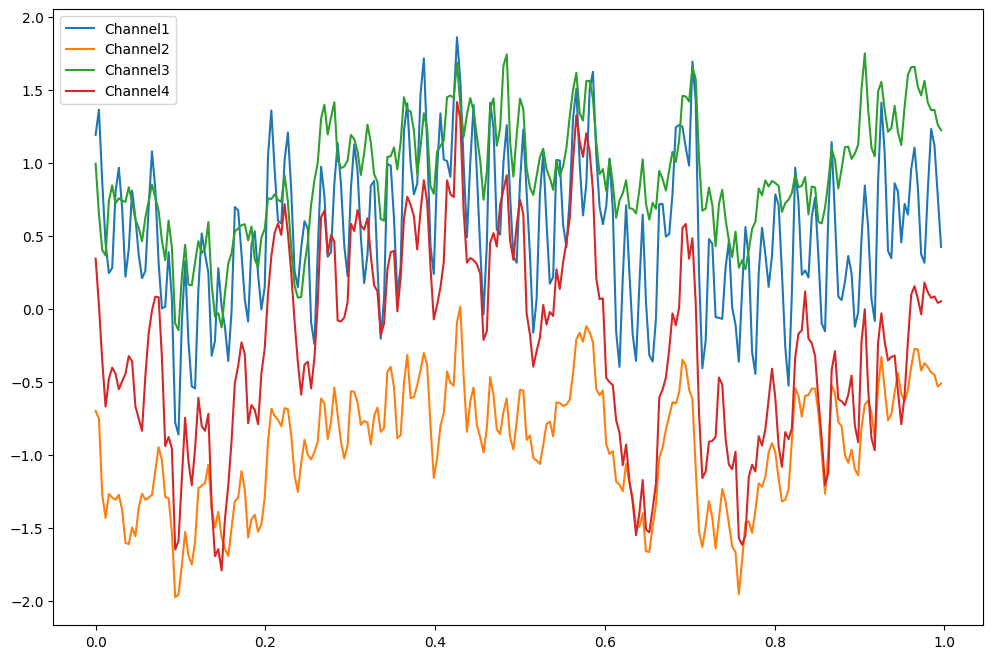

In [7]:
# plot first sample, first four channels
plot_channels(1, X_train[0][:,:4])

## Train model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The program will run on {device}!")

The program will run on cuda!


### Callback functions

In [9]:
def pretrain_callback(model, loss):
    n = model.n_epochs
    metrics_dict = {}
    if n % 1 == 0:
        metrics_dict = eval_classification(model, X_train, y_train[:, 0], X_val, y_val[:, 0], fraction=1)
        print(metrics_dict)
        model.save(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")
    return metrics_dict['F1']

In [10]:
def finetune_callback(model, f1, fraction=1.0):
    n = model.n_epochs
    if model.n_epochs == 1:
        model.finetune_f1 = f1
        torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    # control the saving frequency
    if n % 1 == 0:
        if f1 > model.finetune_f1:
            model.finetune_f1 = f1
            torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    return finetune_callback

## Self-Supervised

In [11]:
start_time = datetime.now()
# Train a COMET model
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=configs.input_dims,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    after_epoch_callback=pretrain_callback,
)

epoch_loss_list, epoch_f1_list = model.fit(
    X_train,
    y_train,
    trial_shuffle = configs.trial_shuffle,
    verbose=configs.verbose,
    n_epochs=configs.n_epochs,
    masks = configs.masks,
    factors = configs.factors
)

end_time = datetime.now()
print(f'Duration: {end_time - start_time}')

Epoch #1: loss=43.34987357567097
{'Accuracy': 0.8421052631578947, 'Precision': 0.8425814001647025, 'Recall': 0.8421052631578947, 'F1': 0.8420503815600363, 'AUROC': 0.9210153604955371, 'AUPRC': 0.9197776428653126}
Epoch #2: loss=28.109571391138537
{'Accuracy': 0.8399122807017544, 'Precision': 0.8401887691500576, 'Recall': 0.8399122807017544, 'F1': 0.8398797462646184, 'AUROC': 0.9255383868113265, 'AUPRC': 0.9230316401774283}
Epoch #3: loss=23.4111222891972
{'Accuracy': 0.8432017543859649, 'Precision': 0.8432034049101883, 'Recall': 0.8432017543859649, 'F1': 0.843201565868303, 'AUROC': 0.9264797822406894, 'AUPRC': 0.9227020223074474}
Epoch #4: loss=21.261517228751348
{'Accuracy': 0.8432017543859649, 'Precision': 0.8432083565781121, 'Recall': 0.8432017543859649, 'F1': 0.8432010003125977, 'AUROC': 0.9271927419975378, 'AUPRC': 0.9222853848775705}
Epoch #5: loss=20.325121452068462
{'Accuracy': 0.8464912280701754, 'Precision': 0.8465328914776034, 'Recall': 0.8464912280701755, 'F1': 0.8464866138

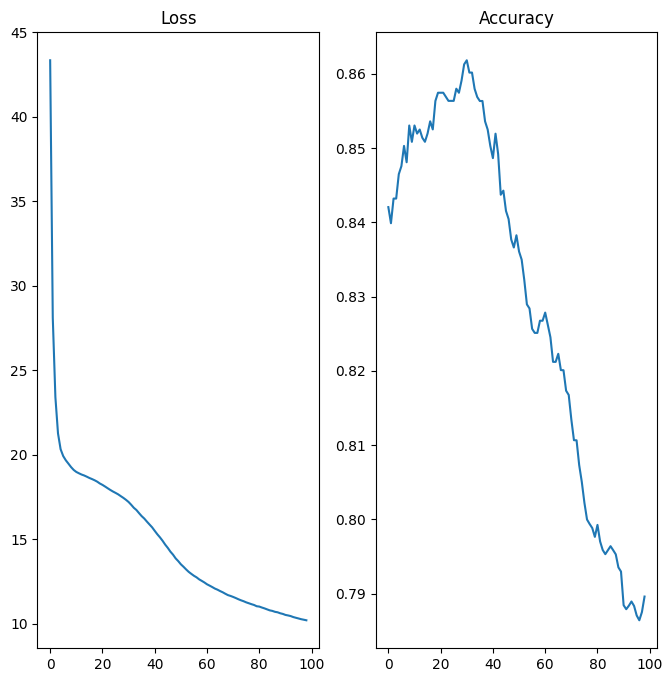

In [12]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Linear evaluation

In [13]:
start_time = datetime.now()
seed_everything(RANDOM_SEED)
pretrain_model = COMET(
    input_dims=configs.input_dims,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    after_epoch_callback=pretrain_callback,
)

pretrain_model.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")

start_logging(RANDOM_SEED, logging_directory)
val_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_val, y_val[:, 0])
print("Linear evaluation for validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_test, y_test[:, 0])
print("Linear evaluation for test set\n",test_metrics_dict)
print()
stop_logging()

Linear evaluation for validation set
 {'Accuracy': 0.7911184210526315, 'Precision': 0.7997775216380945, 'Recall': 0.7911184210526316, 'F1': 0.7895990585388641, 'AUROC': 0.9000305382425363, 'AUPRC': 0.8958982526283876}


## Full fine-tuning

In [14]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes).to(device)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [15]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_100, finetune_epochs=configs.finetune_epochs_100, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_100, fraction=configs.fraction_100, device=device, callback=finetune_callback)

In [16]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_100}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_100} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_100} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

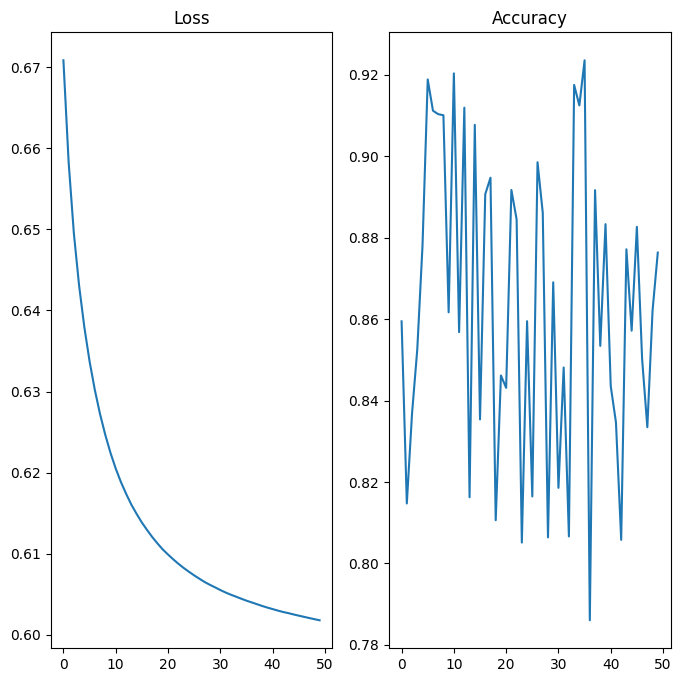

In [17]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Semi-supervised

### 30% label

In [18]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes).to(device)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [19]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_30,finetune_epochs=configs.finetune_epochs_30, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_30, fraction=configs.fraction_30, device=device, callback=finetune_callback)

In [20]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_30}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_30} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_30} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

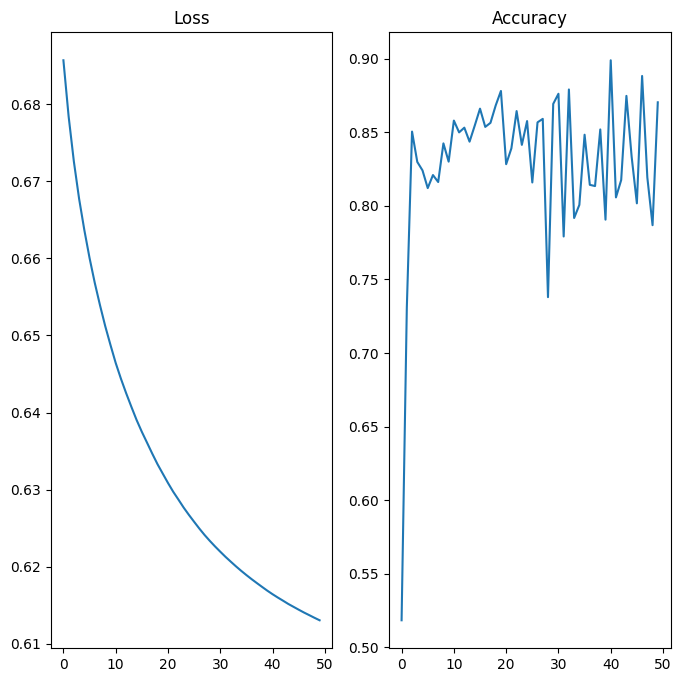

In [21]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

### 10% label

In [22]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes).to(device)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [23]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_10,finetune_epochs=configs.finetune_epochs_10, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_10, fraction=configs.fraction_10, device=device, callback=finetune_callback)

In [24]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_10}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_10} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_10} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

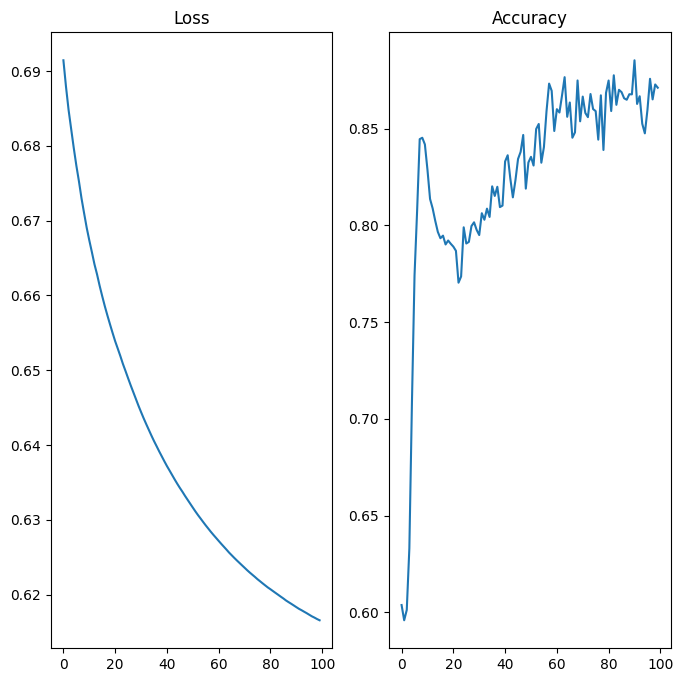

In [25]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

### 1% label

In [26]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes).to(device)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [27]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_1,finetune_epochs=configs.finetune_epochs_1, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_1, fraction=configs.fraction_1, device=device, callback=finetune_callback)

In [28]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_1}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_1} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_1} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

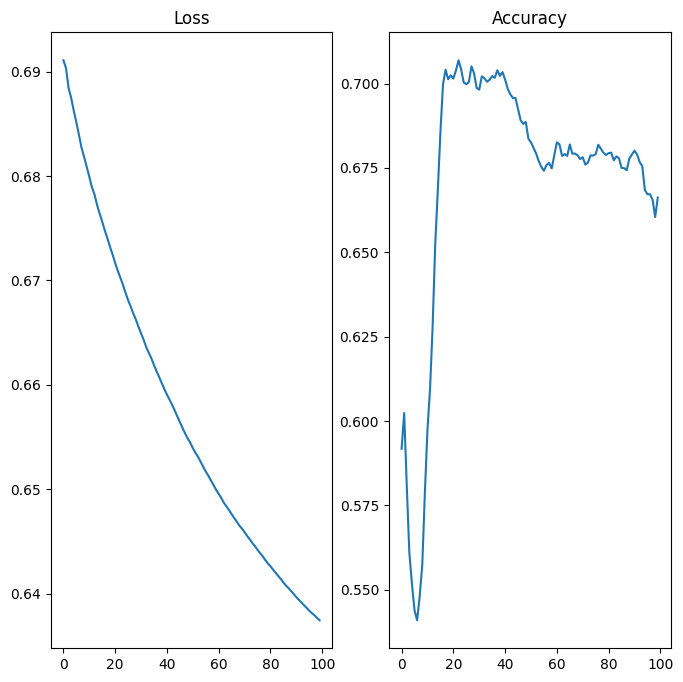

In [29]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

In [30]:
end_time = datetime.now()
print(f'Duration: {end_time - start_time}')